# Breve Explicacion 
El objetivo de este cuaderno es el armado de un dataset capaz de servir como un filtro para evitar que a nuestro sistema clasificador de consolidaciones le lleguen imágenes de clases que no es capaz de procesar correctamente. De esta manera, se estaría garantizando que el sistema de soporte a la toma de decisiones clínicas y más aún el sistema de Triage, puedan realizar su tarea de manera óptima. 

A continuación, se muestran los tipos de imágenes que nuestro sistema soporta y aquellos factibles de generar ruido: 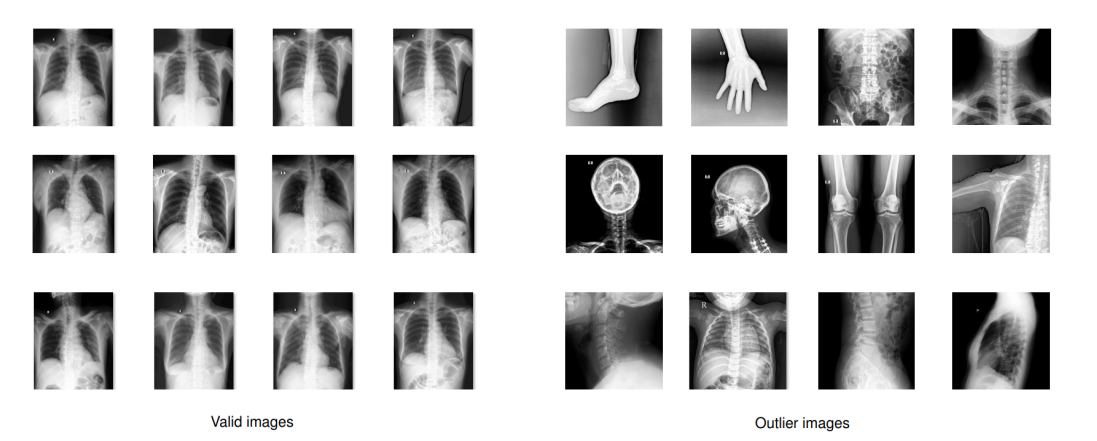

De aquí es importante notar que el sitema fue entrenado únicamente con radiografís de tórax frontales tipo PA. Es decir, es de esperarse que no funcione correctamente con imágnes pertenecientes a las clases AP o lateral de radiografía de tórax así como tambien con radiografías de cualquier otra estructura corporal. 


Por lo tanto, el objetivo de esta parte es filtrar todas las imágenes no corresponden al tipo que analiza nuestro sistema, para garantizar su eficacia.

#Montaje e Importación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np
import os

In [ ]:
# PADCHEST - CHEST Xray - AP_h - PA- L 
pc_train = pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
pc_test = pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [ ]:
# MURA - Elbow - Finger - Forearm - Hand - Hummerus - Shoulder - Wrist
mura_train = pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_MURA.xlsx")
mura_test = pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_MURA.xlsx")

In [ ]:
# HIP 
hip_train = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Cadera/hip_train.csv')
hip_test = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Cadera/hip_test.csv')

# Analisis Exploratorio

In [ ]:
pc_train.head()

,Unnamed: 0,ImageID,ImageDir,Projection
0,0,0/209046467925082585123438173056951670828_2yf7...,0,PA
1,1,1/317153195138727022241940825334565644346_pm1t...,1,PA
2,2,1/157752956223429585284471889321633028328_s661...,1,PA
3,3,2/116049923418608239865298302562509374260_5i35...,2,AP_horizontal
4,4,1/335059767833946941543878820205593617354_h5pe...,1,L


In [ ]:
print(pc_train.Projection.value_counts())
print(pc_train.Projection.value_counts(normalize=True))

PA               10862
L                 5706
AP_horizontal      870
Name: Projection, dtype: int64
PA               0.622893
L                0.327216
AP_horizontal    0.049891
Name: Projection, dtype: float64


In [ ]:
print(pc_test.Projection.value_counts())
print(pc_test.Projection.value_counts(normalize=True))

PA               2716
L                1427
AP_horizontal     217
Name: Projection, dtype: int64
PA               0.622936
L                0.327294
AP_horizontal    0.049771
Name: Projection, dtype: float64


In [ ]:
mura_train.head()

,Unnamed: 0,Path,ImgType
0,0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER
1,1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER
2,2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER
3,3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER
4,4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER


In [ ]:
print(mura_train.ImgType.value_counts())
print(mura_train.ImgType.value_counts(normalize=True))

WRIST       9752
SHOULDER    8379
HAND        5543
FINGER      5106
ELBOW       4931
FOREARM     1825
HUMERUS     1272
Name: ImgType, dtype: int64
WRIST       0.264942
SHOULDER    0.227641
HAND        0.150592
FINGER      0.138720
ELBOW       0.133965
FOREARM     0.049582
HUMERUS     0.034558
Name: ImgType, dtype: float64


In [ ]:
print(mura_test.ImgType.value_counts())
print(mura_test.ImgType.value_counts(normalize=True))

WRIST       659
SHOULDER    563
ELBOW       465
FINGER      461
HAND        460
FOREARM     301
HUMERUS     288
Name: ImgType, dtype: int64
WRIST       0.206131
SHOULDER    0.176103
ELBOW       0.145449
FINGER      0.144198
HAND        0.143885
FOREARM     0.094151
HUMERUS     0.090084
Name: ImgType, dtype: float64


In [ ]:
hip_train.head()

,Unnamed: 0,Path,ImgType
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP


In [ ]:
print(len(hip_train))
print(len(hip_test))

858
215


Para determinar la proporción de imágenes pertenecientes a la clase "Otros", se observó la base de datos del hospital. La realidad es que existe cierta incertidumbre al momento de calcular esta proporción, debido a la gran proporción de descripciones de objetos que son del tipo Nan. 
Sin embargo, se realizó una estimación con aquellas series que si se encontraban anotadas. La misma arrojó un valor aproximado de 13%. Por lo tanto, se agregarán imágenes correspondientes a cada clase de manera de conseguir dicho porcentaje. 

# Preparación del Set de Train

In [ ]:
len(pc_train)*0.13

2266.94

In [ ]:
# Cantidad de imágenes que debe tener cada una de mis subcategorías de "Otros"
2267/8

283.375

In [ ]:
mura_train['start_path'] ='/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/'
mura_train['entire_Path'] = mura_train['start_path'] + mura_train['Path']
mura_train = mura_train.drop(['start_path','Path'],axis=1)
cols = ['Unnamed: 0','entire_Path','ImgType']
mura_train = mura_train[cols]
hip_train = hip_train.rename(columns={'Path':'entire_Path'})

In [ ]:
hip_train.head()

,Unnamed: 0,entire_Path,ImgType
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP


In [ ]:
mura_train.head()

,Unnamed: 0,entire_Path,ImgType
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER


In [ ]:
mura_train_sample = pd.DataFrame(np.concatenate([mura_train[mura_train['ImgType']=='WRIST'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='SHOULDER'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='FINGER'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='ELBOW'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='HUMERUS'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='HAND'].sample(n=283),
                                                mura_train[mura_train['ImgType']=='FOREARM'].sample(n=283),
                                                hip_train.sample(n=283)]),
                                 columns = ('id', 'Path','ImgType'))
mura_train_sample.head()

,id,Path,ImgType
0,24863,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
1,21238,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
2,23934,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
3,25414,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
4,28919,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST


In [ ]:
mura_train_sample.Path.values[0]

'/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/MURA-v1.1/train/XR_WRIST/patient07767/study1_negative/image1.png'

In [ ]:
other_train = mura_train_sample.sample(frac=1)
len(other_train)

2264

In [ ]:
other_train['class_name'] = 'Otro'

In [ ]:
other_train

,id,Path,ImgType,class_name
395,794,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
749,14455,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,FINGER,Otro
303,8029,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
838,12857,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,FINGER,Otro
541,3041,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
...,...,...,...,...
2098,205,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP,Otro
866,17001,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,ELBOW,Otro
2096,607,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP,Otro
1850,29513,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,FOREARM,Otro


In [ ]:
other_train.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/other_train.csv')

In [ ]:
pc_train = pc_train.drop(columns=['ImageDir'],axis=1)

In [ ]:
pc_train['class_name'] = pc_train['Projection']
pc_train

,Unnamed: 0,ImageID,Projection,class_name
0,0,0/209046467925082585123438173056951670828_2yf7...,PA,PA
1,1,1/317153195138727022241940825334565644346_pm1t...,PA,PA
2,2,1/157752956223429585284471889321633028328_s661...,PA,PA
3,3,2/116049923418608239865298302562509374260_5i35...,AP_horizontal,AP_horizontal
4,4,1/335059767833946941543878820205593617354_h5pe...,L,L
...,...,...,...,...
17433,17433,6/109629994783055558159663901799709452741_lp06...,PA,PA
17434,17434,4/17550048962462292354390950562258261629_4enke...,PA,PA
17435,17435,5/221707020021396800591902578337530315742_vh7j...,PA,PA
17436,17436,1/194600924615827283147265593297145671589_z7g8...,PA,PA


In [ ]:
pc_train['start_path'] = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/'
pc_train['entire_path'] = pc_train['start_path'] + pc_train['ImageID']

In [ ]:
pc_train.head()

,Unnamed: 0,ImageID,Projection,class_name,start_path,entire_path
0,0,0/209046467925082585123438173056951670828_2yf7...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
1,1,1/317153195138727022241940825334565644346_pm1t...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
2,2,1/157752956223429585284471889321633028328_s661...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
3,3,2/116049923418608239865298302562509374260_5i35...,AP_horizontal,AP_horizontal,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
4,4,1/335059767833946941543878820205593617354_h5pe...,L,L,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...


In [ ]:
#pc_train = pc_train.drop(['start_path','ImageID'],axis=1)
cols = ['Unnamed: 0','entire_path','Projection','class_name']
pc_train = pc_train[cols]

In [ ]:
pc_train.head()

,Unnamed: 0,entire_path,Projection,class_name
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L


In [ ]:
train_filter_set = pd.DataFrame(
    np.concatenate([pc_train,other_train]),columns=('unnamed','Path','ImgType','class_name')
)
train_filter_set.head()

,unnamed,Path,ImgType,class_name
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L


In [ ]:
train_filter_set = train_filter_set.sample(frac=1)
train_filter_set

,unnamed,Path,ImgType,class_name
11925,11925,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2198,2198,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
8719,8719,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L
11332,11332,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
10701,10701,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
...,...,...,...,...
11149,11149,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
6824,6824,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L
15047,15047,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
13922,13922,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA


In [ ]:
train_filter_set.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_filter_set.csv')

In [ ]:
train_filter_set.class_name.value_counts(normalize=True)

PA               0.551315
L                0.289615
Otro             0.114912
AP_horizontal    0.044158
Name: class_name, dtype: float64

# Preparación del Set de Test

In [ ]:
len(pc_test)*0.13

566.8000000000001

In [ ]:
567/8

70.875

In [ ]:
mura_test['start_path'] ='/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/'
mura_test['entire_Path'] = mura_test['start_path'] + mura_test['Path']
mura_test = mura_test.drop(['start_path','Path'],axis=1)
cols = ['Unnamed: 0','entire_Path','ImgType']
mura_test = mura_test[cols]
hip_test = hip_test.rename(columns={'Path':'entire_Path'})

In [ ]:
hip_test.head()

,Unnamed: 0,entire_Path,ImgType
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,HIP


In [ ]:
mura_test.head()

,Unnamed: 0,entire_Path,ImgType
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST


In [ ]:
mura_test_sample = pd.DataFrame(np.concatenate([mura_test[mura_test['ImgType']=='WRIST'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='SHOULDER'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='FINGER'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='ELBOW'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='HUMERUS'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='HAND'].sample(n=71),
                                                mura_test[mura_test['ImgType']=='FOREARM'].sample(n=71),
                                                hip_test.sample(n=71)]),
                                 columns = ('id', 'Path','ImgType'))
mura_test_sample.head()

,id,Path,ImgType
0,620,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
1,408,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
2,578,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
3,558,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST
4,627,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,WRIST


In [ ]:
mura_test_sample.Path.values[0]

'/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/MURA-v1.1/valid/XR_WRIST/patient11379/study1_negative/image2.png'

In [ ]:
other_test = mura_test_sample.sample(frac=1)
len(other_test)

568

In [ ]:
other_test['class_name'] = 'Otro'

In [ ]:
pc_test = pc_test.drop(columns=['ImageDir'],axis=1)

In [ ]:
pc_test['class_name'] = pc_test['Projection']
pc_test.head()

,Unnamed: 0,ImageID,Projection,class_name
0,0,5/117461681536540587607592076584888612953_wmoy...,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,PA,PA


In [ ]:
pc_test['start_path'] = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/'
pc_test['entire_path'] = pc_test['start_path'] + pc_test['ImageID']
pc_test.head()

,Unnamed: 0,ImageID,Projection,class_name,start_path,entire_path
0,0,5/117461681536540587607592076584888612953_wmoy...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
1,1,0/214260817085057432303623958907855926368_jrl2...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
2,2,4/144306045728819370188471558682816175107_vhmd...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
3,3,1/213096160366986458367121958911602047465_wble...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...
4,4,4/280022667207150747197673782766436308679_15wi...,PA,PA,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...


In [ ]:
pc_test = pc_test.drop(['start_path','ImageID'],axis=1)
cols = ['Unnamed: 0','entire_path','Projection','class_name']
pc_test = pc_test[cols]

In [ ]:
pc_test

,Unnamed: 0,entire_path,Projection,class_name
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
...,...,...,...,...
4355,4355,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4356,4356,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L
4357,4357,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4358,4358,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L


In [ ]:
test_filter_set = pd.DataFrame(
    np.concatenate([pc_test,other_test]),columns=('unnamed','Path','ImgType','class_name')
)
test_filter_set.head()

,unnamed,Path,ImgType,class_name
0,0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1,1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2,2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3,3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4,4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA


In [ ]:
test_filter_set = test_filter_set.sample(frac=1)
test_filter_set

,unnamed,Path,ImgType,class_name
4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
...,...,...,...,...
41,41,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1108,1108,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4407,1967,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
460,460,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,L


In [ ]:
test_filter_set.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set.csv')

In [ ]:
test_filter_set.class_name.value_counts(normalize=True)

PA               0.551136
L                0.289570
Otro             0.115260
AP_horizontal    0.044034
Name: class_name, dtype: float64

# Separar en dos
El hecho de clasificar PA, AP, L y otros resultó en un modelo que confunde AP con PA mucho más que el modelo previo sin la categoría otros. Proponemos un primer modelo de filtrado de otras, vs imagenes de tórax y la implementación del previamente desarrollado luego. 

In [ ]:
train_filter_set = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_filter_set.csv')
test_filter_set = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set.csv')

In [ ]:
test_filter_set.head()

,Unnamed: 0,unnamed,Path,ImgType,class_name
0,4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
1,3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
2,3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
3,1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA
4,4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA


In [ ]:
test_filter_set['class_name'] = test_filter_set.class_name.replace(["PA", "L", "AP_horizontal"], "Chest")
train_filter_set['class_name'] = train_filter_set.class_name.replace(["PA", "L", "AP_horizontal"], "Chest")
test_filter_set

,Unnamed: 0,unnamed,Path,ImgType,class_name
0,4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
1,3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
2,3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
3,1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4,4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
...,...,...,...,...,...
4923,41,41,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4924,1108,1108,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4925,4407,1967,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
4926,460,460,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,Chest


In [ ]:
test_filter_set

,Unnamed: 0,unnamed,Path,ImgType,class_name
0,4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
1,3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
2,3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
3,1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4,4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
...,...,...,...,...,...
4923,41,41,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4924,1108,1108,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,Chest
4925,4407,1967,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,SHOULDER,Otro
4926,460,460,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,L,Chest


In [ ]:
train_filter_set.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_filter_set_v2.csv')
test_filter_set.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set_v2.csv')

In [ ]:
test_filter_set.class_name.value_counts()

Chest    4360
Otro      568
Name: class_name, dtype: int64